<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/lab_solutions/Labs/Lab07_gradientDescent_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Gradient descent on Rosenbrock (SOLUTIONS)


We'll use the very classic Rosenbrock test function; see [wikipedia](https://en.wikipedia.org/wiki/Rosenbrock_function) for a plot of what it looks like in 2D

Learning objectives
- See how to implement gradient descent
- Compare gradient descent and Newton's method for optimization
- Look at alternatives (e.g., alternating minimization/coordinate descent, Nelder Mead, etc.) and see how they compare[link text](https://)

We have 4 tasks:
1. Implement gradient descent, and use it to minimize the Rosenbrock function
2. Implement Newton's method (for optimization), and again minimize Rosenbrock
3. Implement alternating minimization for 2D Rosenbrock
4. (Optional) Try some of `scipy.optimize.minimize`'s builtin solvers

**Deliverables**

1. Turn in a PDF showing your implementation of gradient descent and evidence that it works

You do *not* need to turn in the work on the other 3 tasks


APPM 4600. Copyright Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause license

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
from scipy.optimize import rosen, rosen_der, rosen_hess
import scipy.optimize
from matplotlib import colors, cm

# Task 0. Warmup -- investigate the Rosenbrock function

Setup the problem and see how the functions work

In [135]:
n = 2 # pick a dimension. Let's do n=2 for visualization reasons

xSolution = np.ones(n)  # this is a known solution; see wikipedia
errFcn    = lambda x : np.linalg.norm(x - xSolution)

x0 = .1*np.ones(n)

print('Function g(x)', rosen(x0))
print('Gradient of g', rosen_der(x0))
print('Hessian of g')
print(rosen_hess(x0))

Function g(x) 1.62
Gradient of g [-5.4 18. ]
Hessian of g
[[-26. -40.]
 [-40. 200.]]


Plot it...

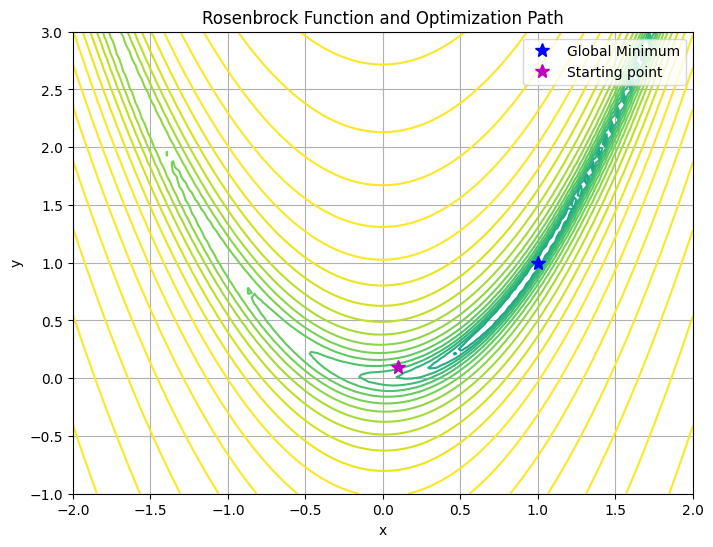

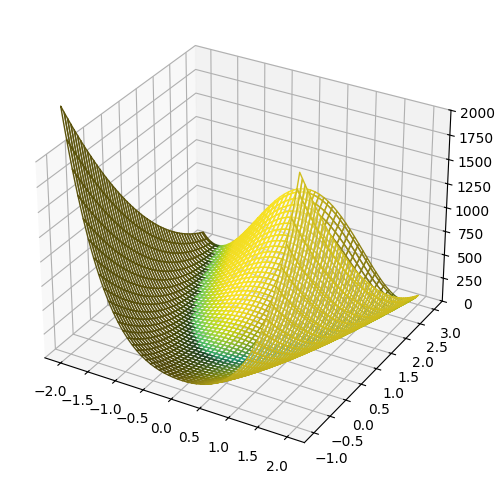

In [116]:
# Create a contour plot of the Rosenbrock function
Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Zgrid = rosen([Xgrid, Ygrid])

plt.figure(figsize=(8, 6))
clr_norm = colors.LogNorm(vmin=Zgrid.min(), vmax=100)
plt.contour(Xgrid, Ygrid, Zgrid, levels=np.logspace(-0.5, 3.5, 20),
            norm=clr_norm )
plt.plot(1,1, 'b*', markersize=10, label='Global Minimum')
plt.plot(x0[0],x0[1], 'm*', markersize=10, label='Starting point')
plt.title('Rosenbrock Function and Optimization Path')
plt.xlabel('x')
plt.ylabel('y')
zoom = False
if zoom:
    plt.xlim(0.05, 1.25)
    plt.ylim(0.05, 1.25)
plt.legend()
plt.grid(True)
plt.show()

# 3D plot
fig, ax = plt.subplots(figsize=(8, 6),subplot_kw={"projection": "3d"})
clrs = cm.viridis(clr_norm(Zgrid))
surf = ax.plot_surface( Xgrid, Ygrid, Zgrid,facecolors=clrs)#,rstride=3,cstride=3)
ax.set_zlim(0, 2000)
surf.set_facecolor((1,1,1,.35))

## Task 1: minimize the Rosenbrock function using gradient descent

Your function should solve a generic problem $$\min_{\vec{x}\in\mathbb{R}^n} g(\vec{x})$$
and take as inputs at least:
1. `g` (code that computes $g(\vec{x})$)
2. `gprime` (code that computes $\nabla g(\vec{x})$)
3. `x0` (a starting guess, of the right size)
4. a stepsize for gradient descent

For this lab, I suggest using a fixed stepsize (determined by trial and error), though if you are ambitious you can try a linesearch.  See [Backtracking line search -- Armijo conditions](https://en.wikipedia.org/wiki/Backtracking_line_search#Algorithm) for a good one (good enough, and easy to code); try $c=10^{-4}$ and $\tau=0.9$ for reasonable values.

Then test your gradient descent code on the Rosenbrock function.
The prebuilt code `rosen` and `rosen_der` compute the function value and gradient of the Rosenbrock function for you.

We know where the true minimum is, so you can check your answer. You should aim to find a solution $\vec{x}$ such that $\|\vec{x} - \vec{x}_\text{true minimum}\|_2 \le 10^{-4}$. How many iterations does this take?

In [125]:
def gradientDescent(g,gprime,x0,stepsize, tol = 1e-6, maxIts = 1000, \
                    errFcn = None, verbose=True, linesearch = False, \
                    linesearch_maxits = 30, linesearch_alpha = 0.9, \
                    linesearch_beta = 1e-4, min_stepsize = 1e-6):
    x = np.array(x0,copy=True)
    errHist = []
    maxIts = int(maxIts)
    gx = g(x)
    for k in range(maxIts):
        grad = gprime(x)

        if linesearch:
            # check for sufficient decrease
            gx_old = gx
            for i in range(linesearch_maxits):
                xNew = x - stepsize*grad
                gx = g(xNew)
                if gx < gx_old - linesearch_beta*stepsize*np.linalg.norm(grad)**2:
                    break
                if stepsize < min_stepsize:
                    break
                stepsize = linesearch_alpha*stepsize
            if i == 0:
                # we accepted on the first step, so let's be more aggressive next iteration
                stepsize = stepsize/linesearch_alpha
        else:
            xNew = x - stepsize*grad
        if errFcn is not None:
            errHist.append(errFcn(xNew))
            if verbose and (k<10 or (k<100 and (k+1)%10==0) or (k<1000 and (k+1)%100==0) or (k+1)%1000==0):
                print(f'Iter {k+1:3d}, error {errHist[-1]:9.2e}, stepsize {stepsize:9.2e}')
        if np.isclose(xNew,x,atol=tol, rtol=tol).all():
            print('Reached tolerance')
            break
        x = xNew
        if not np.isfinite(x).all():
            print(f'NaN encountered at iter {k}, stepsize was {stepsize:.2e}')
            break
    return x, errHist

x0 = .1*np.ones(n)

stepsize = .001 # < .01
x, errHist = gradientDescent(rosen,rosen_der,x0,stepsize, errFcn=errFcn, \
                             linesearch=False, maxIts=1e5, tol= 1e-8)
print('Now with a linesearch')
x, errHist = gradientDescent(rosen,rosen_der,x0,stepsize, errFcn=errFcn, \
                             linesearch=True, maxIts=1e5, tol= 1e-8)

# The linesearch is a bit faster, but the real benefit is that you didn't
# have to guess a good stepsize

Iter   1, error  1.28e+00, stepsize  1.00e-03
Iter   2, error  1.29e+00, stepsize  1.00e-03
Iter   3, error  1.29e+00, stepsize  1.00e-03
Iter   4, error  1.30e+00, stepsize  1.00e-03
Iter   5, error  1.30e+00, stepsize  1.00e-03
Iter   6, error  1.30e+00, stepsize  1.00e-03
Iter   7, error  1.30e+00, stepsize  1.00e-03
Iter   8, error  1.30e+00, stepsize  1.00e-03
Iter   9, error  1.30e+00, stepsize  1.00e-03
Iter  10, error  1.30e+00, stepsize  1.00e-03
Iter  20, error  1.29e+00, stepsize  1.00e-03
Iter  30, error  1.28e+00, stepsize  1.00e-03
Iter  40, error  1.27e+00, stepsize  1.00e-03
Iter  50, error  1.25e+00, stepsize  1.00e-03
Iter  60, error  1.24e+00, stepsize  1.00e-03
Iter  70, error  1.23e+00, stepsize  1.00e-03
Iter  80, error  1.22e+00, stepsize  1.00e-03
Iter  90, error  1.20e+00, stepsize  1.00e-03
Iter 100, error  1.19e+00, stepsize  1.00e-03
Iter 200, error  1.08e+00, stepsize  1.00e-03
Iter 300, error  9.92e-01, stepsize  1.00e-03
Iter 400, error  9.16e-01, stepsiz

## Task 2: minimize the Rosenbrock function using Newton's method for minimization

To minimize $g(\vec{x})$, Newton's method for minimization iterates as follows:
$$\vec{x}^{(k+1)} = \vec{x}^{(k)} - H_k^{-1} \nabla g(\vec{x}^{(k)})$$
where
$$H_k = \nabla^2 g(\vec{x}^{(k)})$$
is the **Hessian** of $g$ (like the second derivative). The prebuilt code `rosen_hess` computes the Hessian of the Rosenbrock function for you.

You should write generic code that takes in `g`, `gprime` and the `Hessian`, then use it to minimize the Rosenbrock function.

You don't need to have a stepsize (i.e., a stepsize of 1 is fine).  You can do a linesearch if you want, but in that case, you should always start at the trial stepsize of 1. In order to get superlinear or quadratic convergence, you need to eventually be using a stepsize of 1.

How many iterations does it take to converge compared to gradient descent?

What are possible downsides of Newton's method (especially if we work in a dimension $n>2$)?

In [126]:
def NewtonForOptimization(g,gprime,Hessian,x0, tol = 1e-6, maxIts = 1000, \
                    errFcn = None, verbose=True, linesearch = False, \
                    linesearch_maxits = 30, linesearch_alpha = 0.9, \
                    linesearch_beta = 1e-4, min_stepsize = 1e-6):
    x = np.array(x0,copy=True)
    errHist = []
    maxIts = int(maxIts)
    gx = g(x)
    for k in range(maxIts):
        grad = gprime(x)
        H    = Hessian(x) # should be symmetric
        # scipy.linalg is better than np.linalg here since we can tell it that H is symmetric
        v    = sla.solve(H, grad, assume_a = 'symmetric')
        stepsize = 1 # always start at 1 for Newton's method
        if linesearch:
            # check for sufficient decrease
            gx_old = gx
            for i in range(linesearch_maxits):
                xNew = x - stepsize*v
                gx = g(xNew)
                if gx < gx_old - linesearch_beta*stepsize*np.dot(v,grad):
                    break
                if stepsize < min_stepsize:
                    break
                stepsize = linesearch_alpha*stepsize
        else:
            xNew = x - stepsize*v
        if errFcn is not None:
            errHist.append(errFcn(xNew))
            if verbose and (k<20 or (k+1)%10==0):
                print(f'Iter {k+1:3d}, error {errHist[-1]:9.2e}, stepsize {stepsize:9.2e}')
        if np.isclose(xNew,x,atol=tol, rtol=tol).all():
            print('Reached tolerance')
            break
        x = xNew
        if not np.isfinite(x).all():
            print(f'NaN encountered at iter {k}, stepsize was {stepsize:.2e}')
            break
    return x, errHist

x, errHist = NewtonForOptimization(rosen,rosen_der,rosen_hess, x0, tol = 1e-12,  \
                    errFcn = errFcn, linesearch=False )

Iter   1, error  1.38e+00, stepsize  1.00e+00
Iter   2, error  1.00e+00, stepsize  1.00e+00
Iter   3, error  6.55e-01, stepsize  1.00e+00
Iter   4, error  1.16e-01, stepsize  1.00e+00
Iter   5, error  2.95e-03, stepsize  1.00e+00
Iter   6, error  1.75e-06, stepsize  1.00e+00
Iter   7, error  7.04e-13, stepsize  1.00e+00
Iter   8, error  0.00e+00, stepsize  1.00e+00
Reached tolerance


## Task 3: alternating minimization (i.e., a variant of coordinate descent)
Since we're working in 2D, let's write $\vec{x} = (x,y)$. Then we can write the Rosenbrock function as:
$$g(x,y) = (1-x)^2 + 100( y-x^2 )^2
= 1 - 2x + x^2 + 100( y^2 - 2yx^2 + x^4)$$

If we knew what $y$ is, then we just have a nice 1D polynomial in $x$ and we could minimize that (how? set the derivatives equal to zero and check which of these roots, aka critical points, is the smallest).

Similarly, if we knew $x$, then we could solve for $y$.

This suggests the **alternating minimization** approach: for iterations $k=1,2,\ldots$, we do
$$x_{k+1} = \text{argmin}_x \quad g(x,y_k)$$
$$y_{k+1} = \text{argmin}_y \quad g(x_{k+1},y)$$

In the context of solving linear systems, this is known as *Gauss-Seidel*.

It doesn't always work, or if it does it may not work well, but for many problems it's easy to try.

When should it work well? If $g(x,y) = g_1(x) + g_2(y)$, then it should work in one step! We call this a *separable* problem.  More generally, if the *level sets* of $g$ are nice circles, then the approach should work well.  If the level sets are instead very *elliptical*, it won't work well: we'll have a lot of **zig-zagging**.

Your **task** is to implement alternating minimization to solve Rosenbrock.

In [136]:
# Alternating minimization, for, specialized for n=2 case
from numpy.polynomial import Polynomial
# expects coefficients in order of increasing degree
# i.e., (1, 2, 3) give 1 + 2*x + 3*x**2.
if n != 2:
    raise Exception('Only works for n=2')

xHist = []
def callback_function(xk):
    xHist.append(xk)

(x,y) = x0
callback_function( [x,y] )
for k in range(100):
    # for a fixed y, solve for x
    P = Polynomial( [1-100*y, -2, 1-200*y,0,100] )
    roots = P.deriv().roots() # find the critical points of the derivative
    vals = P(roots)
    x = roots[np.argmin(vals)]
    # for a fixed x, solve for y
    P = Polynomial( [1-2*x+x**2+100*x**4, -200*x**2, 100 ] )
    roots = P.deriv().roots() # find the critical points of the derivative
    vals = P(roots)
    y = roots[np.argmin(vals)]

    fcn = rosen( [x,y] )
    err = errFcn( [x,y] )
    callback_function( [x,y] )
    if (k<10 or (k+1)%100==0):
      print(f'Iter {k+1:5d}, error {err:9.2e}, fcn {fcn:9.2e}, (x,y) = ({x:5.3f},{y:5.3f})')

xHist = np.array(xHist)


Iter     1, error  1.11e+00, fcn  4.47e-01, (x,y) = (0.332,0.110)
Iter     2, error  1.10e+00, fcn  4.28e-01, (x,y) = (0.346,0.120)
Iter     3, error  1.08e+00, fcn  4.12e-01, (x,y) = (0.358,0.128)
Iter     4, error  1.07e+00, fcn  3.97e-01, (x,y) = (0.370,0.137)
Iter     5, error  1.06e+00, fcn  3.83e-01, (x,y) = (0.381,0.145)
Iter     6, error  1.04e+00, fcn  3.71e-01, (x,y) = (0.391,0.153)
Iter     7, error  1.03e+00, fcn  3.59e-01, (x,y) = (0.400,0.160)
Iter     8, error  1.02e+00, fcn  3.49e-01, (x,y) = (0.409,0.168)
Iter     9, error  1.01e+00, fcn  3.39e-01, (x,y) = (0.418,0.175)
Iter    10, error  1.00e+00, fcn  3.30e-01, (x,y) = (0.426,0.181)
Iter   100, error  5.89e-01, fcn  8.89e-02, (x,y) = (0.702,0.492)


If you saved a history vector of all the points, then the code below will plot them

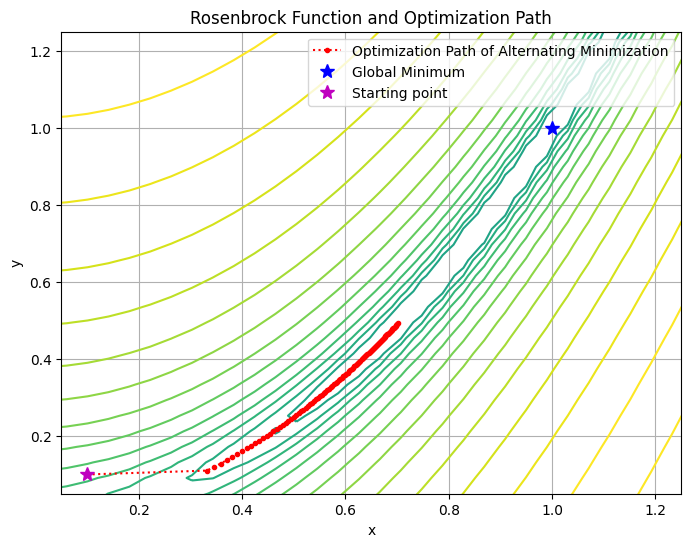

In [137]:
# Create a contour plot of the Rosenbrock function
Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Zgrid = rosen([Xgrid, Ygrid])


plt.figure(figsize=(8, 6))
plt.contour(Xgrid, Ygrid, Zgrid, levels=np.logspace(-0.5, 3.5, 20),
            norm=colors.LogNorm(vmin=Zgrid.min(), vmax=100) )
plt.plot(xHist[:, 0], xHist[:, 1], 'r:', marker='o', \
         markersize=3, label='Optimization Path of Alternating Minimization')
plt.plot(1,1, 'b*', markersize=10, label='Global Minimum')
plt.plot(x0[0],x0[1], 'm*', markersize=10, label='Starting point')
plt.title('Rosenbrock Function and Optimization Path')
plt.xlabel('x')
plt.ylabel('y')
zoom = True
if zoom:
    plt.xlim(0.05, 1.25)
    plt.ylim(0.05, 1.25)
plt.legend()
plt.grid(True)
plt.show()

## Task 4 (optional): try some of the `scipy.optimize` builtin solvers

See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

Some solvers only require function evaluations $g$, others (in fact, most) also require a gradient $\nabla g$, and some (e.g., Newton and variants) also require the Hessian $\nabla^2g$ (or more exactly, they require a function that computes a Hessian-vector-product (HvP): if you give it $\vec{x}$ and $\vec{v}$, the HvP should return $\nabla^2 g(\vec{x})\vec{v}$.

A famous method that only uses $g$ and not $\nabla g$ (so it is "derivative-free") is `Nelder-Mead`. It's famous because it's been around for a long time, not because it is good.  It's also popular because people like the fact that you don't have to give it a derivative/gradient --- it's easier to use!

A prototypical method that requires $g$ and $\nabla g$ is `BFGS` or `L-BFGS-B`, which are **quasi-Newton** methods and generally state-of-the-art.

A method with uses the Hessian is `trust-exact`, which is like Newton's method but adds in a "trust-region" to make it much more robust.

Compare the methods on the Rosenbrock test function in dimension $n=10$

In [132]:
from time import time
import warnings

n  = 10
x0 = 0.1*np.ones(n)
xSolution = np.ones(n)
errFcn    = lambda x : np.linalg.norm(x - xSolution)

# First, figure out which methods use gradients and which use Hessians
# This isn't necessary, we just want this info to make a nice table later.
methods = ['Nelder-Mead','Powell','COBYLA','BFGS','L-BFGS-B','CG','TNC',
        'SLSQP','Newton-CG','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']
useGradient = [True]*len(methods)
useHessian  = [True]*len(methods)
for (j,meth) in enumerate(methods):
    with warnings.catch_warnings(record=True) as warn:
        warnings.simplefilter("always")
        out = scipy.optimize.minimize(rosen, x0, method=meth, jac=rosen_der, hess=rosen_hess, tol=1e-10)
        for i in range(len(warn)):
            if "hess" in str(warn[i].message):
                useHessian[j] = False
            if "grad" in str(warn[i].message):
                useGradient[j] = False

In [133]:
opts = {'disp':False}
nFcnEvalList = []
errList      = []
timeList     = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    # Supress the warnings about methods that ignore the Hessian or gradient information
    for meth in methods:
        start = time()
        out = scipy.optimize.minimize(rosen, x0, method=meth, jac=rosen_der, \
                                      hess=rosen_hess, tol=1e-10, \
                                      options=opts )
        errList.append(errFcn(out.x))
        nFcnEvalList.append(out.nfev)
        timeList.append(time() - start)
        print(f'Method {meth:20s} took {float(nFcnEvalList[-1]):4.0f} iterations, error is {errList[-1]:5.2e}, time {timeList[-1]:5.1f} sec')

print(f'Dimension is {n}')
print('| Method | Iterations | Error | Time | use gradients? | use Hessians? |')
print('| -- | -- | -- | -- | -- | -- |')
for (i,meth) in enumerate(methods):
    print(f'| {meth} | {float(nFcnEvalList[i]):4.0f}  |  {errList[i]:5.1e} | {timeList[i]:.1f} sec. | {useGradient[i]} | {useHessian[i]} |')


Method Nelder-Mead          took 2000 iterations, error is 2.04e+00, time   0.1 sec
Method Powell               took 10000 iterations, error is 2.55e-08, time   0.3 sec
Method COBYLA               took 1000 iterations, error is 2.53e+00, time   2.0 sec
Method BFGS                 took   88 iterations, error is 6.89e-13, time   0.0 sec
Method L-BFGS-B             took   71 iterations, error is 5.61e-07, time   0.0 sec
Method CG                   took  802 iterations, error is 4.08e-11, time   0.1 sec
Method TNC                  took  101 iterations, error is 9.76e-01, time   0.0 sec
Method SLSQP                took   98 iterations, error is 1.05e-07, time   0.0 sec


/tmp/ipython-input-1629349313.py:10: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  out = scipy.optimize.minimize(rosen, x0, method=meth, jac=rosen_der, \


Method Newton-CG            took   66 iterations, error is 1.34e-12, time   0.0 sec
Method trust-constr         took   53 iterations, error is 1.12e-10, time   0.1 sec
Method dogleg               took    1 iterations, error is 2.85e+00, time   0.0 sec
Method trust-ncg            took   70 iterations, error is 2.17e-13, time   0.0 sec
Method trust-exact          took   33 iterations, error is 8.60e-14, time   0.0 sec
Method trust-krylov         took 2001 iterations, error is 3.33e-09, time   0.6 sec
Dimension is 10
| Method | Iterations | Error | Time | use gradients? | use Hessians? |
| -- | -- | -- | -- | -- | -- |
| Nelder-Mead | 2000  |  2.0e+00 | 0.1 sec. | False | False |
| Powell | 10000  |  2.5e-08 | 0.3 sec. | False | False |
| COBYLA | 1000  |  2.5e+00 | 2.0 sec. | False | False |
| BFGS |   88  |  6.9e-13 | 0.0 sec. | True | False |
| L-BFGS-B |   71  |  5.6e-07 | 0.0 sec. | True | False |
| CG |  802  |  4.1e-11 | 0.1 sec. | True | False |
| TNC |  101  |  9.8e-01 | 0.0 sec.

After copy-pasting that markdown output into a text cell, we have a nice table:

Dimension is 10
| Method | Iterations | Error | Time | use gradients? | use Hessians? |
| -- | -- | -- | -- | -- | -- |
| Nelder-Mead | 2000  |  2.0e+00 | 0.1 sec. | False | False |
| Powell | 10000  |  2.5e-08 | 0.3 sec. | False | False |
| COBYLA | 1000  |  2.5e+00 | 2.0 sec. | False | False |
| BFGS |   88  |  6.9e-13 | 0.0 sec. | True | False |
| L-BFGS-B |   71  |  5.6e-07 | 0.0 sec. | True | False |
| CG |  802  |  4.1e-11 | 0.1 sec. | True | False |
| TNC |  101  |  9.8e-01 | 0.0 sec. | True | False |
| SLSQP |   98  |  1.0e-07 | 0.0 sec. | True | False |
| Newton-CG |   66  |  1.3e-12 | 0.0 sec. | True | True |
| trust-constr |   53  |  1.1e-10 | 0.1 sec. | True | True |
| dogleg |    1  |  2.8e+00 | 0.0 sec. | True | True |
| trust-ncg |   70  |  2.2e-13 | 0.0 sec. | True | True |
| trust-exact |   33  |  8.6e-14 | 0.0 sec. | True | True |
| trust-krylov | 2001  |  3.3e-09 | 0.6 sec. | True | True |

What did we learn?  Nelder-Mead doesn't work very well.  


In general, if we had re-run this for different dimensions $n$, my rules-of-thumb wisdom are:
- in small dimensions, derivative-free methods work OK. Most things work great in 1D or 2D.  (Note: in 1D, there are specialized methods, so don't use `scipy.optimize.minimize` here)
- methods that use the Hessian work well in all dimensions, but each step is very slow in high dimensions. These methods are generally good if you need a very very high accuracy solution
- gradient-based methods are a nice compromise, and a good default first choice, especially quasi-Newton methods. They are not too expensive per iteration, and more accurate than derivative-fee methods.  `BFGS` is a classic.